Base on the data from 
https://www.kaggle.com/datasets/anandshaw2001/customer-churn-dataset/data provided by anandshaw2001, licenced CC0.



In [55]:
#librairies imporation
import pandas as pd
import numpy as np
from faker import Faker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


The objective of this EDA is to show which factor in the data explain a exit from a customer.
Then to predict which customer is most likely to quit and what are the main caracteristic for this customer.

# Data Exploration

In [36]:
#Opening csv file:
file = pd.read_csv("Churn_Modelling.csv")
data = file.copy()
fake = Faker()
# Generate random names for each row in the 'Surname' column
data['Surname'] = data['Surname'].apply(lambda _: fake.last_name())
data.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Chan,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Johnston,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Robles,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,White,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Griffin,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


RowNumber : A unique identifier for each row in the dataset.

CustomerId : Unique customer identification number.

Surname : The last name of the customer (for privacy reasons, consider anonymizing this data if not already done).

CreditScore : The customer's credit score at the time of data collection.

Geography : The customer's country or region, providing insights into location-based trends in churn.

Gender : The customer's gender.

Age : The customer's age, valuable for demographic analysis.

Tenure : The number of years the customer has been with the bank.

Balance : The customer's account balance.

NumOfProducts : The number of products the customer has purchased or subscribed to.

HasCrCard : Indicates whether the customer has a credit card (1) or not (0).

IsActiveMember : Indicates whether the customer is an active member (1) or not (0).

EstimatedSalary : The customer's estimated salary.

Exited : The target variable, indicating whether the customer has churned (1) or not (0).

In [37]:
#Quick dive into some metrics
mean_credit_score_countries = data.groupby("Geography")["CreditScore"].mean()
mean_credit_score_gender = data.groupby("Gender")["CreditScore"].mean()

#Creation of group by age
# Define age group boundaries
age_group_boundaries = [18, 25, 40, 55, 70, 100]
age_group_labels = ['18-25', '26-40', '41-55', '56-70', '70+']

# Create age groups using pd.cut()
data['AgeGroup'] = pd.cut(data['Age'], bins=age_group_boundaries, labels=age_group_labels, right=False)
data['AgeGroup']
mean_credit_score_agegroup = data.groupby("AgeGroup")["CreditScore"].mean()

print("Mean credit score by country :", mean_credit_score_countries, 
      "Mean credit score by gender :",mean_credit_score_gender,
      "Mean credit score by group of ages :", mean_credit_score_agegroup,
      sep = "\n\n")

Mean credit score by country :

Geography
France     649.668329
Germany    651.453567
Spain      651.333872
Name: CreditScore, dtype: float64

Mean credit score by gender :

Gender
Female    650.831389
Male      650.276892
Name: CreditScore, dtype: float64

Mean credit score by group of ages :

AgeGroup
18-25    653.973742
26-40    651.306510
41-55    648.206963
56-70    648.967168
70+      667.324503
Name: CreditScore, dtype: float64


C:\Users\bapti\AppData\Local\Temp\ipykernel_8280\403935563.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_credit_score_agegroup = data.groupby("AgeGroup")["CreditScore"].mean()


C:\Users\bapti\AppData\Local\Temp\ipykernel_8280\4061348643.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data = data.groupby("AgeGroup")["CreditScore"].mean())


<Axes: xlabel='AgeGroup', ylabel='CreditScore'>

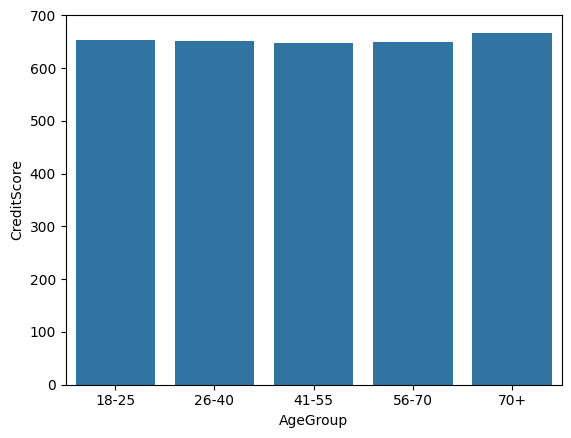

In [38]:
sns.barplot(data = data.groupby("AgeGroup")["CreditScore"].mean())

C:\Users\bapti\AppData\Local\Temp\ipykernel_8280\715138344.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data = data.groupby("AgeGroup")["EstimatedSalary"].mean())


<Axes: xlabel='AgeGroup', ylabel='EstimatedSalary'>

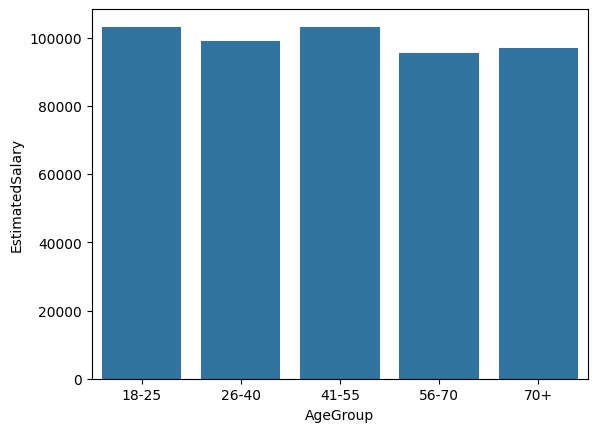

In [39]:
sns.barplot(data = data.groupby("AgeGroup")["EstimatedSalary"].mean())

C:\Users\bapti\AppData\Local\Temp\ipykernel_8280\2434599838.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data = data.groupby("AgeGroup")["Exited"].mean())


<Axes: xlabel='AgeGroup', ylabel='Exited'>

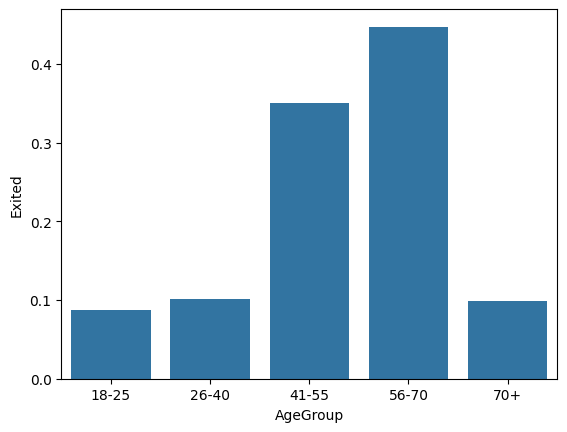

In [40]:
sns.barplot(data = data.groupby("AgeGroup")["Exited"].mean())

The age of the personne have a huge impact

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   RowNumber        10000 non-null  int64   
 1   CustomerId       10000 non-null  int64   
 2   Surname          10000 non-null  object  
 3   CreditScore      10000 non-null  int64   
 4   Geography        10000 non-null  object  
 5   Gender           10000 non-null  object  
 6   Age              10000 non-null  int64   
 7   Tenure           10000 non-null  int64   
 8   Balance          10000 non-null  float64 
 9   NumOfProducts    10000 non-null  int64   
 10  HasCrCard        10000 non-null  int64   
 11  IsActiveMember   10000 non-null  int64   
 12  EstimatedSalary  10000 non-null  float64 
 13  Exited           10000 non-null  int64   
 14  AgeGroup         10000 non-null  category
dtypes: category(1), float64(2), int64(9), object(3)
memory usage: 1.1+ MB


# Data Clustering and Modelling

In [42]:
from sklearn.preprocessing import LabelEncoder

# Initialize a LabelEncoder
le = LabelEncoder()

# Perform Label Encoding on the 'Geography' column
data['Geography_Id'] = le.fit_transform(data['Geography'])
data['GenderId'] = le.fit_transform(data['Gender'])
one_hot_encoded = data['AgeGroup'].str.get_dummies()
data = pd.concat([data, one_hot_encoded], axis=1)
data.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,EstimatedSalary,Exited,AgeGroup,Geography_Id,GenderId,18-25,26-40,41-55,56-70,70+
0,1,15634602,Chan,619,France,Female,42,2,0.00,1,...,101348.88,1,41-55,0,0,0,0,1,0,0
1,2,15647311,Johnston,608,Spain,Female,41,1,83807.86,1,...,112542.58,0,41-55,2,0,0,0,1,0,0
2,3,15619304,Robles,502,France,Female,42,8,159660.80,3,...,113931.57,1,41-55,0,0,0,0,1,0,0
3,4,15701354,White,699,France,Female,39,1,0.00,2,...,93826.63,0,26-40,0,0,0,1,0,0,0
4,5,15737888,Griffin,850,Spain,Female,43,2,125510.82,1,...,79084.10,0,41-55,2,0,0,0,1,0,0


In [43]:
X = data[['CreditScore', 'Geography_Id', 'GenderId',"Age", 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']]
y = data['Exited']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = rf.feature_importances_


feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

print(feature_importances_df)
#Here I would like to see if my age group add a influence on the score. 


           Feature  Importance
3              Age    0.240168
9  EstimatedSalary    0.148584
0      CreditScore    0.144056
5          Balance    0.141131
6    NumOfProducts    0.130736
4           Tenure    0.081658
8   IsActiveMember    0.039419
1     Geography_Id    0.037012
7        HasCrCard    0.018837
2         GenderId    0.018400


We confirm that Age is the primary factor for Churn Customers.

In [44]:
scaler = preprocessing.StandardScaler()
data_norm = data.copy()
numerical_cols = ['CreditScore', 'Geography_Id', 'GenderId',"Age", 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
for cols in numerical_cols: 
    data_norm[cols] = scaler.fit_transform(np.array(data_norm[cols]).reshape(-1, 1))
#Normalisation of my values
to_explain = data_norm["Exited"]
data_norm = data_norm.drop(['RowNumber', 'CustomerId', 'Exited', 'Gender', 'Geography', 'Surname','AgeGroup', '18-25', '26-40','41-55','56-70','70+'], axis = 1)
data_norm.head()
#We don't need our age group anymore, and calcul will be faster

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Id,GenderId
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,-0.901886,-1.095988
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,1.515067,-1.095988
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687,-0.901886,-1.095988
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,-0.901886,-1.095988
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276,1.515067,-1.095988


In [45]:
X = data_norm[numerical_cols]
y = to_explain

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
#Classic Random Forest Classifier

Confusion Matrix:
[[2339   77]
 [ 316  268]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.78      0.46      0.58       584

    accuracy                           0.87      3000
   macro avg       0.83      0.71      0.75      3000
weighted avg       0.86      0.87      0.86      3000



We can see that we have a good precision score for customer that don't leave.
But for churn customer, we don't have good metrics, specially for recall, witch means that the model miss a lot of churn customers.

We need a better model

In [46]:
X = data_norm[numerical_cols]
y = to_explain

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knc = KNeighborsClassifier(n_neighbors=4)

knc.fit(X_train, y_train)

y_pred = knc.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
#NeighborsClassifier

Confusion Matrix:
[[2348   68]
 [ 419  165]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      2416
           1       0.71      0.28      0.40       584

    accuracy                           0.84      3000
   macro avg       0.78      0.63      0.65      3000
weighted avg       0.82      0.84      0.81      3000



This model is worse than the previous one

In [51]:
X = data_norm[numerical_cols]
y = to_explain

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

neural = MLPClassifier(max_iter=5000)
neural.fit(X_train, y_train)

y_pred = neural.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
#NeuralNetworks

Confusion Matrix:
[[2255  161]
 [ 276  308]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2416
           1       0.66      0.53      0.58       584

    accuracy                           0.85      3000
   macro avg       0.77      0.73      0.75      3000
weighted avg       0.85      0.85      0.85      3000



In [56]:
#For gaussian, I reduce the data to the top 5 columns that have a impact to get better performances

X = data_norm[["Age", "EstimatedSalary", "CreditScore","Balance","NumOfProducts"]]
y = to_explain

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#I also add a PCA to improve performances
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

kernel = ExpSineSquared() + WhiteKernel(noise_level=1e-6)
gpc = GaussianProcessClassifier(kernel = kernel, random_state=42, optimizer=fmin_l_bfgs_b)
gpc.fit(X_train, y_train)

y_pred = gpc.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Conclusion

The best model seems to be the RandomForestClassifier.
Yet, it have low performance on the prediction for customer who quit.
We could improve this by adding more data to our dataset or try others Classifier like Gaussian Cla